# Numerical solutions to differential equations: The Euler and Runge Kutta methods.

_Author: louise.dash@ucl.ac.uk
Last updated: 17.02.2021_

In this session, we're going to start looking at how to solve differential equations numerically. 

There are pre-existing python modules that will do this for you - like [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp),
but as physicists it's important that you understand exactly how these methods work, so rather than using pre-existing modules as a [black box](http://en.wikipedia.org/wiki/Black_box), we're going to start from the basics.

In this session we're going to solve first-order ordinary differential equations of the form

$$ 
\frac{dx}{dt} = f(x,t)
$$

to obtain a solution $x(t)$ over some time interval $t_0 \leq t \leq t_f$. (We'll come to second-order equations in the next session). We'll start with the simplest approach, [Euler](https://en.wikipedia.org/wiki/Leonhard_Euler)'s method, and refine this until we get to the most useful (and most widely-used) approach, the fourth-order [Runge](https://en.wikipedia.org/wiki/Carl_David_Tolm%C3%A9_Runge)-[Kutta](https://en.wikipedia.org/wiki/Martin_Wilhelm_Kutta) method.


If you want to read further on this, then Newman *"Computational Physics"*, Chapter 8 section 1 is a great resource, upon which some of the material in this notebook is based.


As always, we'll start by importing all the modules we need in this notebook.



In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt


## Euler method

Euler's method takes a very simple approach to solving ordinary differential equations. For an equation of the form
$$ 
\frac{dx}{dt} = f(x,t)
$$
and a given starting condition for some $t$, we can use a Taylor expansion to solve the equation at a later time $t+ h$:
$$
x(t+h) = x(t) + h \frac{{\rm d} x}{{\rm d} t} + \frac{1}{2} h^2 \frac{{\rm d}^2 x}{{\rm d t}^2} + \ldots \\ 
\qquad = x(t) + h f(x,t) + {\rm O}(h^2).
$$
Euler's method discards all the terms of order $h^2$ and higher, and applies this repeatedly for intervals of size $h$. We start off at $t = t_0$ (usually $t_0 = 0$), and propagate through the $t$-values, incrementing by $h$ each time, until we reach the final value of $t$.


Let's see how this works in practice.

We'll use it to solve the equation 

$$ \frac{ d x}{ d t} = -x^3 + \sin t,$$

to find $x(t)$, with the initial condition of $x = 0$ at $t = 0$. This is a first-order, linear differential equation, but note that it's non-separable.

The first thing to do is to write a function that implements the right-hand side of this equation:


In [37]:
def f(x,t):
    ''' Definition of our numerical function
    Inputs:
    x: a value or array of x values
    t: time at which to evaluate the function
    Outputs:
    f(x,t): function evaluated for this x and t'''
    
    return -2*np.exp(-t) + np.sin(x*t)
    #return -x**3 + np.sin(t) # our function

    

In order to find $x(t)$, we need to specify what time interval we want to solve for, and specify the total number of steps we want to use. We can then create an array of $t$-points (time points):

In [38]:
a = 0.0          # Start of interval
b = 10.0         # end of interval
N = 1000# number of steps. 1000 gives a nice smooth line
h = (b-a)/N      # size of each step, i.e. delta t
print("Step size h is", h)
x = 0.0          # initial condition

tpoints = np.arange(a,b,h) # array of time points

print(tpoints)

Step size h is 0.01
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1

We can write a function that implements Euler's method by creating a loop over all the $t$-points. On the first iteration of the loop (i.e. $t=0$), we already have a value for $x$: the starting value. For the second iteration of the loop ($t = 0 + h$), we calculate the new value of $x$ based on the function we wrote above. This then propagates to the subsequent iterations of the loop until we have a value of $x$ for each value of $t$. We then return the entire array of xpoints.

In [39]:
def Euler(x,tpoints):
    '''Euler method function.
    Inputs: initial x-value, array of t-values
    Also depends on step h (global variable) and
    requires the function f(x,t) to be defined.
    Returns: array of propagated xpoints
    '''
    xpoints = []          # create an empty array of xpoints
    
    for t in tpoints:     # loop over all the elements of tpoints
        xpoints.append(x) # append the current value of x to the solution array.
        x = x + h*f(x,t)  # calculate the next value of x
       
    return xpoints

Now let's use this to solve the system, and plot the resulting function.

<IPython.core.display.Javascript object>


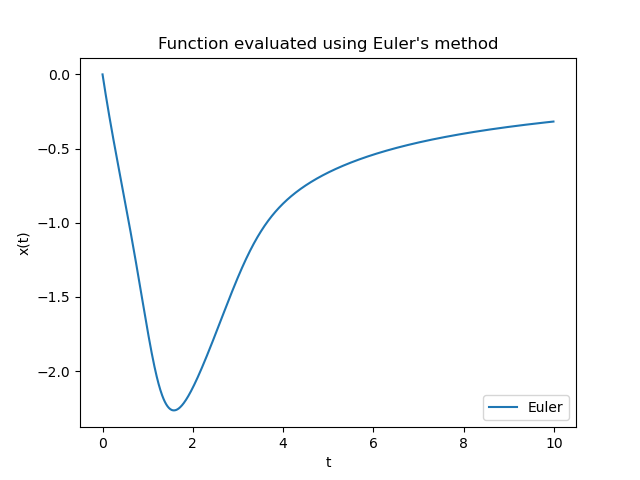

In [40]:
xpointsEuler = Euler(x,tpoints) # calculate x(t) using Euler method

plt.figure()
plt.plot(tpoints,xpointsEuler, label="Euler")
plt.title("Function evaluated using Euler's method")
plt.legend(loc="lower right")
plt.xlabel("t")
plt.ylabel("x(t)");

Maybe you can see the downside to this approach - at each stage we introduce an error due to all the terms in $h^2$ and higher that we discarded. 


One way of reducing the overall error is to make $h$ smaller, but this then means we have to do more calculations to cover the same $t$-range, and hence the calculation is slower.

Another way of improving the results would be to keep the $h^2$ term in the Taylor expansion, i.e. to calculate 
$$ \frac{1}{2} h^2 \frac{d^2 x}{dt^2} = \frac{1}{2} h^2 \frac{df}{dt}, $$
but this would only work if we have an explicit expression for $f(x,t)$ in order to calculate $\frac{df}{dt}$, which we don't necessarily have (for example, if we have $f(x,t)$ in the form of a discrete set of experimental data points).

Fortunately, there is another method that is easy to implement, and doesn't require any derivatives of $f(x,t)$ - this is the [Runge](https://en.wikipedia.org/wiki/Carl_David_Tolm%C3%A9_Runge)-[Kutta](https://en.wikipedia.org/wiki/Martin_Wilhelm_Kutta) method. Actually, it's a whole series of methods, and we'll start by looking at the simplest one, the second-order Runge-Kutta method.

## Second-order Runge Kutta method

In the second-order Runge Kutta method, we do a Taylor expansion around $t + \frac{1}{2}h$. Manipulation of this then leads to an expression which eliminates the terms in $h^2$, leaving an error of order ${\rm O}(h^3)$. This derivation is included in the separate pdf appendix on Moodle for those that are interested (you don't need to understand the details of the derivation to use the method itself, but it's useful background).

Here are the second-order Runge-Kutta equations,
$$
k_1 = hf(x,t), \\
k_2 = hf(x + \frac{1}{2}k_1, t+\frac{1}{2}h), \\
x(t+h) = x(t) + k_2,
$$

and here is the second-order Runge Kutta implemented as a function:

In [41]:
def RungeKutta2(x,tpoints):
    '''Second-order Runge Kutta function.
    Inputs: initial x-value, array of t-values
    Also depends on step h (global variable) and
    requires the function f(x,t) to be defined.
    Returns: array of propagated xpoints
    '''
    xpoints = []          # initialise empty output array
    for t in tpoints:
        xpoints.append(x) # append the current value of x to the solution array.
        k1 = h * f(x,t)
        k2 = h*f(x+0.5*k1, t+0.5*h)
        x = x + k2        # value of x for this time point.
    return xpoints

Now we can use this to calculate for the original function and compare the two methods:

<IPython.core.display.Javascript object>


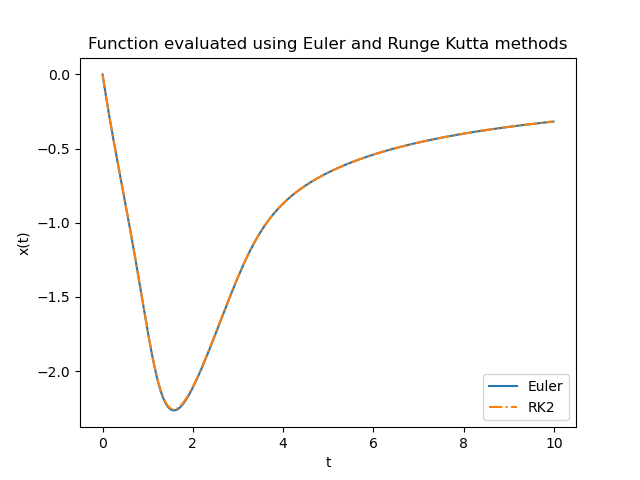

In [42]:
xpointsRK2 = RungeKutta2(x,tpoints)

plt.figure()

plt.plot(tpoints,xpointsEuler,label="Euler")
plt.plot(tpoints,xpointsRK2, "-.", label="RK2")
plt.legend(loc="lower right")
plt.title("Function evaluated using Euler and Runge Kutta methods")
plt.xlabel("t")
plt.ylabel("x(t)");

For this function we can see the results are very similar. We can still get further improvements though, by extending the Runge Kutta method.

### Fourth-order Runge Kutta method

Taking the same approach of Taylor expanding about different points and rearranging the results to eliminate terms we can't / don't want to calculate, it's possible to come up with even more accurate (and complicated) algorithms. In general, the fourth-order Runge Kutta (i.e. the one with errors ${\rm O}(h^5)$)is considered to have the most useful combination of simplicity and accuracy, and is the most widely used method to solve differential equations numerically.

The equations are:
$$
k_1 = h f(x,t), \\
k_2 = h f(x+\frac{1}{2}k_1, t+\frac{1}{2}h), \\
k_3 = h f(x+\frac{1}{2}k_2, t+\frac{1}{2}h), \\
k_4 = h f(x+k_3, t+h), \\
x(t+h) = x(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4).
$$
which we implement, again as a function, in the cell below.

In [43]:
def RungeKutta4(x,tpoints):
    '''Fourth-order Runge Kutta. Inputs: initial x, array of t-values
    Also depends on step h (global variable) and
    requires the function f(x,t) to be defined.
    Returns: array of propagated xpoints'''
    xpoints = [] # a new array for the fourth-order results
    # same procedure as before. When you re-use this function, comment it appropriately!
    for t in tpoints:
        xpoints.append(x) 
        k1 = h*f(x,t)     
        k2 = h*f(x+0.5*k1, t+0.5*h)
        k3 = h*f(x+0.5*k2, t+0.5*h)
        k4 = h*f(x+k3, t+h)
        x = x + (k1 + 2*k2 + 2*k3 + k4)/6
    return xpoints

Now we can compare the results of all three methods:

<IPython.core.display.Javascript object>


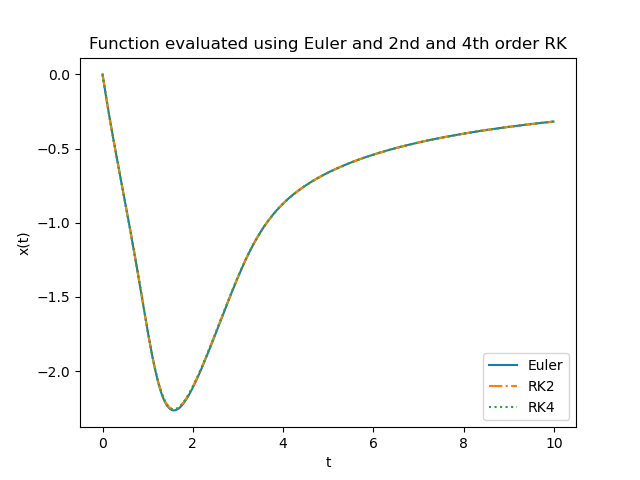

In [44]:
xpointsRK4 = RungeKutta4(x,tpoints)

plt.figure()
plt.plot(tpoints,xpointsEuler)
plt.plot(tpoints,xpointsRK2, "-.")
plt.plot(tpoints,xpointsRK4, ":")
plt.title("Function evaluated using Euler and 2nd and 4th order RK")
plt.legend(["Euler", "RK2", "RK4"],loc="lower right")
plt.xlabel("t")
plt.ylabel("x(t)");

As we can see, all three methods give very similar results. At this point, you may therefore be wondering what the point is of using the (slightly) more complicated 4th-order Runge Kutta method over the Euler method. To see this more clearly, let's increase the value of the step $h$ in the calculations, i.e. decrease the number of $t$-points.

h is now 1.0


<IPython.core.display.Javascript object>


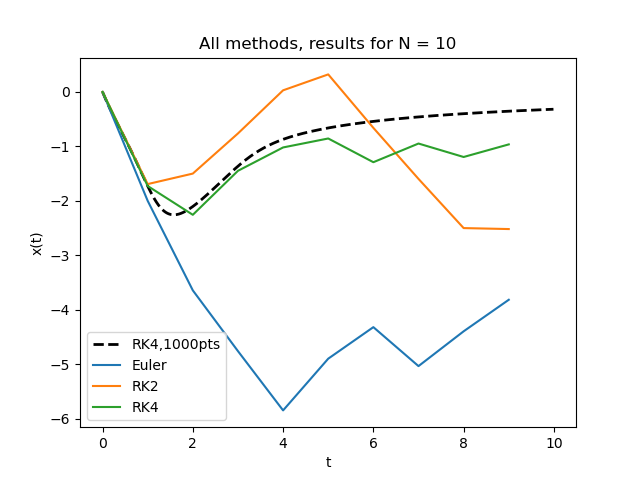

In [45]:
N = 10      # number of steps. Before we used 1000
h = (b-a)/N # size of each step (b and a defined as previously)
print("h is now", h)

# set up and calculate for all three methods with N = 10
tpointsN10 = np.arange(a,b,h) # array of time points
xpointsEulerN10 = Euler(x,tpointsN10)
xpointsRK2N10 = RungeKutta2(x,tpointsN10)
xpointsRK4N10 = RungeKutta4(x,tpointsN10)

# plot the results
plt.figure()
plt.plot(tpoints,xpointsRK4,ls="dashed",lw=2,color="k",label="RK4,1000pts")
plt.plot(tpointsN10,xpointsEulerN10,label="Euler")
plt.plot(tpointsN10,xpointsRK2N10,label="RK2")
plt.plot(tpointsN10,xpointsRK4N10,label="RK4")
plt.legend(loc="lower left",prop={'size':10})
plt.title("All methods, results for N = 10")
plt.xlabel("t")
plt.ylabel("x(t)");

By drastically reducing the number of points to $N=10$ (and thus increasing $h$ from 0.1 to 1), we can see that none of the methods gives a good result. Clearly we've taken things too far. Let's try again with $N = 20$. 

h is now 0.5


<IPython.core.display.Javascript object>


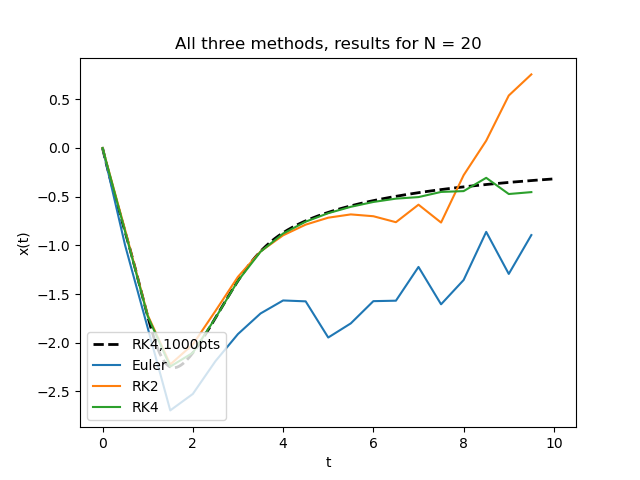

In [46]:
N = 20      # number of steps. Before we used 1000
h = (b-a)/N # size of each step (b and a defined as previously)
print("h is now", h)


# set up and calculate fn using all 3 methods with N = 20
tpointsN20 = np.arange(a,b,h) # array of time points
xpointsEulerN20 = Euler(x,tpointsN20)
xpointsRK2N20 = RungeKutta2(x,tpointsN20)
xpointsRK4N20 = RungeKutta4(x,tpointsN20)

# plot the results
plt.figure()
plt.plot(tpoints,xpointsRK4,ls="dashed",lw=2,color="k",label="RK4,1000pts")
plt.plot(tpointsN20,xpointsEulerN20,label="Euler")
plt.plot(tpointsN20,xpointsRK2N20,label="RK2")
plt.plot(tpointsN20,xpointsRK4N20,label="RK4")
plt.legend(loc="lower left",prop={'size':10})
plt.title("All three methods, results for N = 20")
plt.xlabel("t")
plt.ylabel("x(t)");

Now we can see clearly that the 4th-order Runge Kutta outperforms the other methods, even with relatively few points. As a final demonstration, we'll use $N=30$ to show that there is remarkably little difference from the $N=1000$ results for the 4th-order Runge Kutta (we won't actually quantify this difference here though).

h is now 0.3333333333333333


<IPython.core.display.Javascript object>


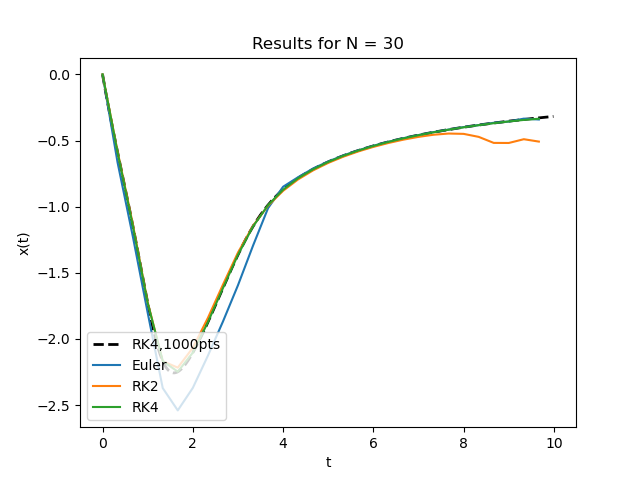

In [47]:
N = 30      # number of steps. Before we used 1000
h = (b-a)/N # size of each step (b and a defined as previously)
print("h is now", h)

# set up and calculate for all three methods with N = 30
tpointsN30 = np.arange(a,b,h) # array of time points
xpointsEulerN30 = Euler(x,tpointsN30)
xpointsRK2N30 = RungeKutta2(x,tpointsN30)
xpointsRK4N30 = RungeKutta4(x,tpointsN30)

# plot results
plt.figure()
plt.plot(tpoints,xpointsRK4,ls="dashed",lw=2,color="k",label="RK4,1000pts")
plt.plot(tpointsN30,xpointsEulerN30,label="Euler")
plt.plot(tpointsN30,xpointsRK2N30,label="RK2")
plt.plot(tpointsN30,xpointsRK4N30,label="RK4")
plt.legend(loc="lower left",prop={'size':10})
plt.title("Results for N = 30")
plt.xlabel("t")
plt.ylabel("x(t)");

<div class="alert alert-success">
<h2>What to do now</h2>

<ol>
<li>Go back to the cell near the top of the notebook where we defined f(x,t). Change the function (best to comment out the original code rather than deleting it) to instead calculate for an exponential decay $-2e^{-t}$ and set the initial value of $x$ to 2.0. Rerun the whole notebook (HINT: use the "Run All" command from the cell menu). What do you notice now about the Euler method?</li>

<li>Try with some other first-order differential equations!</li>
</ol>
</div>


# Your task: Solving for a low-pass filter

### <div class="alert alert-success"> For this task, start a new notebook from scratch. <br> <br> Remember to use text cells to describe your reasoning and results, and comments to annotate the code. <br> <br>You can cut and paste code, equations and images from this notebook if you want,  as long as your notebook makes it clear where you have pasted material and where it came from. </div>

This image shows an electronic circuit for a low-pass filter (if you can't see the image below, follow [this link](http://commons.wikimedia.org/wiki/File:1st_Order_Lowpass_Filter_RC.svg)).  The purpose of such a filter is to cut off the high-frequency parts of the input signal (i.e. it lets the *low* frequency parts of the signal *pass*). 

![circuit diagram](http://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/1st_Order_Lowpass_Filter_RC.svg/500px-1st_Order_Lowpass_Filter_RC.svg.png)


Let $I$ be the current that flows through the resistor $R$ and into the capacitor $C$, with a charge $Q$ on the capacitor. Then we have

$$
IR = V_{\rm in} - V_{\rm out}, \\
 Q = C V_{\rm out}, \\
 I = \frac{dQ}{dt}.$$

Rearranging this gives us a first-order differential equation:
$$ \frac{dV_{\rm out}}{dt} = \frac{1}{RC} ( V_{\rm in} - V_{\rm out}). $$

1. Let the input signal $V_\text{in}$ be a square wave (in Volts) defined as: 
$$ V_{\rm in} = \begin{cases} 1 & \text{if } \lfloor 2t \rfloor\  \text{is even}, \\ 
-1  & \text{if } \lfloor 2t \rfloor\  \text{is odd}, \end{cases} 
$$
where the notation $\lfloor x \rfloor$ means $x$ rounded *down* to the next lowest integer, and $t$ is in units of microseconds ($\mu$s). Write a Python function to represent this mathematical function. 
     * *Hint 1: you may find the function [np.floor](http://docs.scipy.org/doc/numpy/reference/generated/numpy.floor.html) useful here.*
     * *Hint 2: A good way of determining whether an integer $n$ is odd or even is to use a construct like $(-1)^n$*
2. Check your function is working correctly by plotting it in the range $0 \leq t \leq 10 \mu$s. Make sure you include enough time points to ensure the signal is properly square.
2. Solve this using the fourth-order Runge-Kutta method by following the basic procedure we've used in this notebook, i.e.:
     * Write a function to represent the RHS of the differential equation (which will use the function for $V_{\rm in}$)
     * Either use the fourth-order Runge-Kutta function from this notebook (copy and paste, and add your own comments) or rewrite your own version.
     * Define the start and end points, initial conditions, create an array of time values and solve.
3. Plot the input square wave and the output of this (on the same plot) for the range $0\leq t \leq 10$ $\mu$s when the time constant $RC = 1 \mu$s. Repeat this for time constants $RC= 0.1$ and $0.01 \mu$s (i.e. three plots, each with an input and output line). Use the initial condition $V_\text{out} = 0 {\textrm V}$.
4. In a text cell, describe what you see and what you think the circuit is doing. *(Hint: Why do you think it is called a "low-pass filter"?)*
5. Now change the form of $V_\rm{in}$ from a square wave to a sine wave: $V_{\rm in} = \sin(2t)$. What effect does the filter have now?